In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

nba = pd.read_csv('nba_2013.csv')
nba.head()

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,183,277,40,23,46,63,187,328,2013-2014,2013


In [3]:
point_guards = nba[nba.pos == 'PG']
point_guards['ppg'] = point_guards['pts'] / point_guards['g']
# Sanity check, make sure ppg = pts/g
point_guards[['pts', 'g', 'ppg']].head()

/var/folders/vr/1f01f57n6l13s5_b3yh9ztsh0000gn/T/ipykernel_55686/833150659.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  point_guards['ppg'] = point_guards['pts'] / point_guards['g']


,pts,g,ppg
24,930,71,13.098592
29,150,20,7.500000
30,660,79,8.354430
38,666,72,9.250000
50,378,55,6.872727


In [4]:
point_guards = point_guards[point_guards.tov != 0]
point_guards['atr'] = point_guards['ast'] / point_guards['tov']

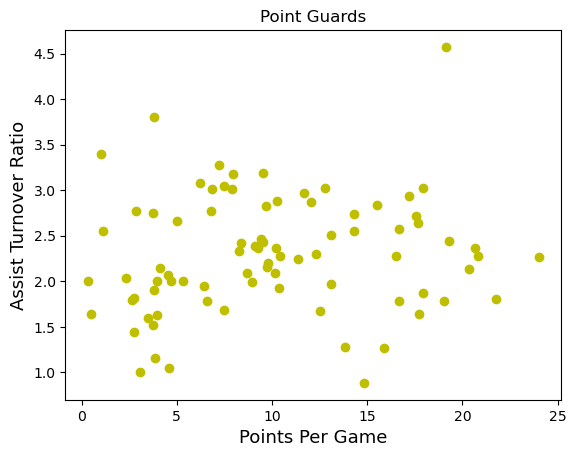

In [5]:
plt.scatter(point_guards['ppg'], point_guards['atr'], c='y')
plt.title("Point Guards")
plt.xlabel('Points Per Game', fontsize=13)
plt.ylabel('Assist Turnover Ratio', fontsize=13)
plt.show()

In [6]:
num_clusters = 5
random_initial_points = np.random.choice(point_guards.index, size=num_clusters)  # 随机取五个球员的index
# Use the random indices to create the centroids
centroids = point_guards.loc[random_initial_points]  # 将这5为作为质心
centroids

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,ast,stl,blk,tov,pf,pts,season,season_end,ppg,atr
30,Jose Barea,PG,29,MIN,79,1,1471,254,656,0.387,...,303,26,0,125,129,660,2013-2014,2013,8.354430,2.424000
272,Damian Lillard,PG,23,POR,82,82,2937,553,1304,0.424,...,457,64,22,193,197,1695,2013-2014,2013,20.670732,2.367876
325,Steve Nash,PG,39,LAL,15,10,313,36,94,0.383,...,86,7,2,31,18,102,2013-2014,2013,6.800000,2.774194
280,Shelvin Mack,PG,23,ATL,73,11,1490,209,501,0.417,...,271,50,2,89,100,544,2013-2014,2013,7.452055,3.044944
110,Stephen Curry,PG,25,GSW,78,78,2846,652,1383,0.471,...,666,128,14,294,194,1873,2013-2014,2013,24.012821,2.265306


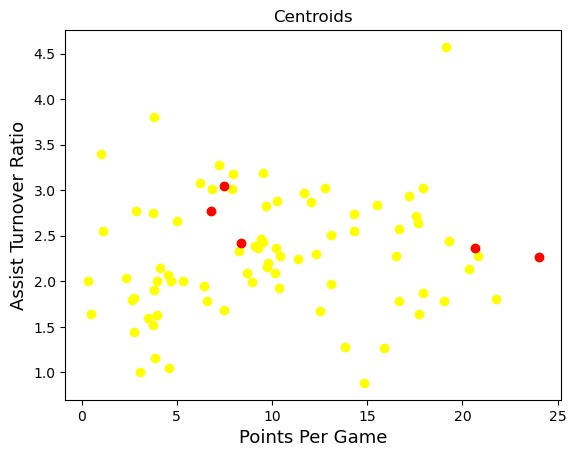

In [7]:
plt.scatter(point_guards['ppg'], point_guards['atr'], c='yellow')
plt.scatter(centroids['ppg'], centroids['atr'], c='red')
plt.title("Centroids")
plt.xlabel('Points Per Game', fontsize=13)
plt.ylabel('Assist Turnover Ratio', fontsize=13)
plt.show()

In [8]:
# 找寻五个质心的坐标（ppg,atr）
def centroids_to_dict(centroids):
    dictionary = dict()
    # iterating counter we use to generate a cluster_id
    counter = 0

    # iterate a pandas data frame row-wise using .iterrows()
    for index, row in centroids.iterrows():
        coordinates = [row['ppg'], row['atr']]
        dictionary[counter] = coordinates
        counter += 1

    return dictionary

centroids_dict = centroids_to_dict(centroids)
centroids_dict

{0: [8.354430379746836, 2.424],
 1: [20.670731707317074, 2.3678756476683938],
 2: [6.8, 2.774193548387097],
 3: [7.4520547945205475, 3.044943820224719],
 4: [24.012820512820515, 2.2653061224489797]}

In [9]:
import math

def calculate_distance(centroid, player_values):
    root_distance = 0

    for x in range(0, len(centroid)):
        difference = centroid[x] - player_values[x]
        squared_difference = difference**2
        root_distance += squared_difference

    euclid_distance = math.sqrt(root_distance)
    return euclid_distance

q = [5, 2]
p = [3,1]

# Sqrt(5) = ~2.24
print(calculate_distance(q, p))

2.23606797749979


In [10]:
# 分类
def assign_to_cluster(row):
    lowest_distance = -1
    closest_cluster = -1

    # 将每个球员和每个质心求距离
    for cluster_id, centroid in centroids_dict.items():
        df_row = [row['ppg'], row['atr']] # 当前球员的坐标位置
        euclidean_distance = calculate_distance(centroid, df_row)

        # 第一次赋值
        if lowest_distance == -1:
            lowest_distance = euclidean_distance
            closest_cluster = cluster_id
        elif euclidean_distance < lowest_distance:
            lowest_distance = euclidean_distance
            closest_cluster = cluster_id
    return closest_cluster  # 得出距离最近的质心，分出类别

point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1) # 每行操作
point_guards[['player', 'cluster']]

,player,cluster
24,D.J. Augustin,0
29,Leandro Barbosa,0
30,Jose Barea,0
38,Jerryd Bayless,0
50,Steve Blake,2
...,...,...
459,Russell Westbrook,1
462,Deron Williams,0
465,Louis Williams,0
467,Mo Williams,0


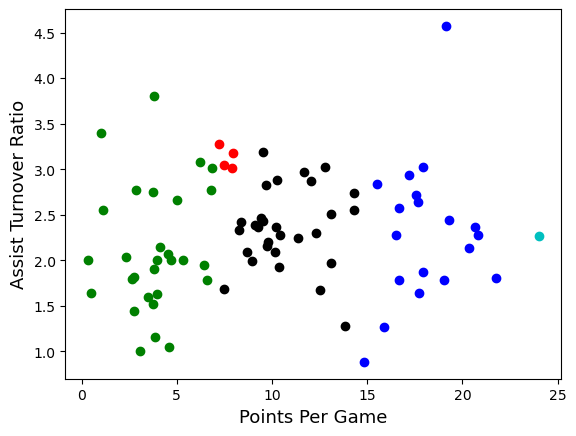

In [11]:
# Visualizing clusters - step 1
def visualize_clusters(df, num_clusters):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    for n in range(num_clusters):
        clustered_df = df[df['cluster'] == n]
        plt.scatter(clustered_df['ppg'], clustered_df['atr'], c=colors[n-1])
        plt.xlabel('Points Per Game', fontsize=13)
        plt.ylabel('Assist Turnover Ratio', fontsize=13)
    plt.show()

visualize_clusters(point_guards, 5)

In [12]:
# def recalculate_centroids(df):
#     new_centroids_dict = dict()
#     # 0..1...2...3...4
#     for cluster_id in range(0, num_clusters):
#         # Finish the logic
#         return new_centroids_dict
#
# centroids_dict = recalculate_centroids(point_guards)

In [13]:
# point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)

In [14]:
# centroids_dict = recalculate_centroids(point_guards)
# point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)

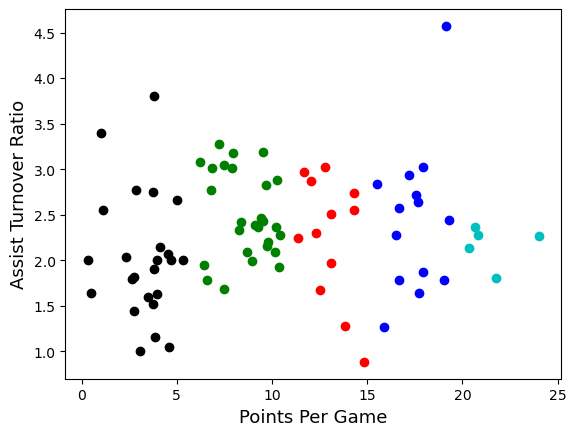

In [15]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(point_guards[['ppg', 'atr']])
point_guards['cluster'] = kmeans.labels_

visualize_clusters(point_guards, num_clusters)